In [7]:
# analysis on-hold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('/Users/dbao/Downloads/research/rc_scripts/analysis')

from final_analysis.process_helper.df_add_features import df_add_features
from final_analysis.process_helper.df_undo_start_end import df_undo_start_end

# Load data

In [3]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [4]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})
data_choice_level = df_add_features(data_choice_level)
sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

### error magnitude before undo

In [10]:
condition = f"(lastUndo == 1)"
accu_error = df_undo_start_end(sc_data_choice_level, condition)

In [14]:
accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

undo_right_sub = accu_error.groupby(['subjects','error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_beginning'])['undo_right'].count()

error_beginning
0    64
1    62
2    25
3     9
4     1
6     1
Name: undo_right, dtype: int64

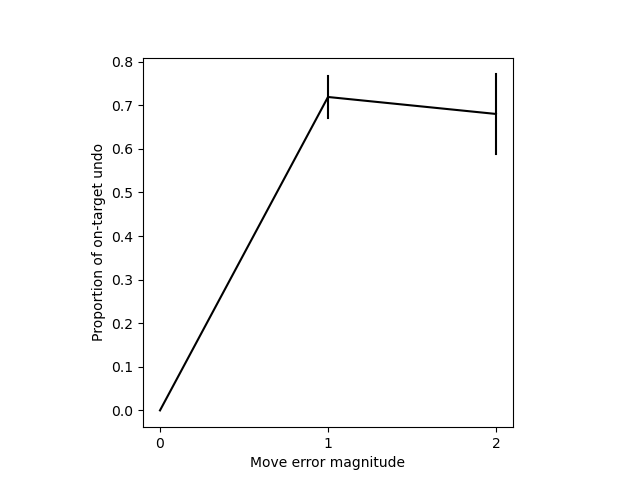

In [15]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.error_beginning<=2],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([0,1,2])

axs.set(xlabel='Move error magnitude', ylabel='Proportion of on-target undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error.png', dpi=300, bbox_inches='tight')

In [ ]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)
accu_error$puzzleID <- as.factor(accu_error[,"puzzleID"])

model_undo_right = lme4::glmer(undo_right ~  1 + error_beginning + (1 |subjects) + (1 | puzzleID),
                                  data = accu_error, 
                                  family = binomial(link="logit"))

# save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + error_beginning + (1 | subjects) + (1 | puzzleID)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2695.3   2717.8  -1343.7   2687.3     2040 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4347 -0.8353 -0.5067  0.9062  2.5517 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.3260   0.571   
 puzzleID (Intercept) 0.2916   0.540   
Number of obs: 2044, groups:  subjects, 90; puzzleID, 46

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.12478    0.11862  -1.052    0.293    
error_beginning  0.25350    0.05254   4.825  1.4e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
errr_bgnnng -0.028
